In [ ]:
!pip install -U accelerate
!pip install -U transformers

## Kaggle 데이터 불러오기
[출처](https://www.kaggle.com/code/erfansobhaei/face-mask-detection-with-resnet34)

In [ ]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
from torchvision.transforms.functional import to_tensor
from torch.utils.data import random_split


import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import warnings

In [ ]:
%cd "/content/drive/MyDrive/PyTorch/data"

/content/drive/MyDrive/PyTorch/data


In [ ]:
data_dir = "."
dataset = ImageFolder(".", transform=ToTensor())
print(len(dataset))
print(dataset.classes)

7553
['with_mask', 'without_mask']


Label:  with_mask (0)


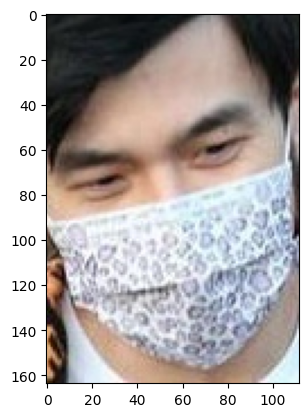

In [ ]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline

def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

show_example(*dataset[800])

In [ ]:
import torchvision.transforms as tt
image_size = (224, 224)

stats = {
    'mean': [0.485, 0.456, 0.406],
    'std': [0.229, 0.224, 0.225]
}
dataset = ImageFolder(data_dir, tt.Compose([
    tt.Resize(image_size),
    tt.ToTensor(),
    tt.Normalize(**stats)
]))

In [ ]:
val_percentage = 0.1
val_size = int(val_percentage * len(dataset))

train_dataset, test_dataset = random_split(dataset, [len(dataset) - val_size, val_size])

## ViT

In [ ]:
from itertools import chain # chain 함수는 여러 개의 iterable을 하나의 iterable로 결합. 리스트를 합치는 데 사용
from collections import defaultdict # defaultdict은 기본값을 가진 dict 생성. 클래스 레이블에 해당하는 이미지의 인덱스 저장
from torch.utils.data import Subset

In [ ]:
def subset_sampler(dataset, classes, max_len): # subset 만들어 반환
  target_idx = defaultdict(list)
  for idx, label in enumerate(dataset.targets):
    target_idx[int(label)].append(idx)

  indices = list(
      chain.from_iterable(
          [target_idx[idx][:max_len] for idx in range(len(classes))]
      )
  )
  return Subset(dataset, indices)

In [ ]:
classes = train_dataset.dataset.classes
class_to_idx = train_dataset.dataset.class_to_idx
print(classes)
print(class_to_idx)

subset_train_dataset = subset_sampler(
    dataset = train_dataset.dataset, classes = train_dataset.dataset.classes, max_len = 1000
)
subset_test_dataset = subset_sampler(
    dataset = test_dataset.dataset, classes = test_dataset.dataset.classes, max_len = 100
)

print(f"Training Data Size : {len(subset_train_dataset)}")
print(f"Testing Data Size : {len(subset_test_dataset)}")
print(train_dataset[0])

['with_mask', 'without_mask']
{'with_mask': 0, 'without_mask': 1}
Training Data Size : 2000
Testing Data Size : 200
(tensor([[[ 1.5982,  1.5982,  1.5982,  ...,  1.5982,  1.5982,  1.5982],
         [ 1.5982,  1.5982,  1.5982,  ...,  1.5982,  1.5982,  1.5982],
         [ 1.5982,  1.5982,  1.5982,  ...,  1.5982,  1.5982,  1.5982],
         ...,
         [ 1.0502,  1.0331,  1.0331,  ..., -1.2103, -0.7137,  0.1939],
         [ 0.9988,  0.9988,  0.9817,  ..., -0.6623, -0.0287,  0.3309],
         [ 1.0331,  1.1187,  0.9132,  ..., -0.0116,  0.1426,  0.2111]],

        [[ 1.5357,  1.5357,  1.5357,  ...,  1.5357,  1.5357,  1.5357],
         [ 1.5357,  1.5357,  1.5357,  ...,  1.5357,  1.5357,  1.5357],
         [ 1.5357,  1.5357,  1.5357,  ...,  1.5357,  1.5357,  1.5357],
         ...,
         [ 0.8704,  0.8529,  0.8529,  ..., -1.2304, -0.7577,  0.0476],
         [ 0.8179,  0.8179,  0.8004,  ..., -0.7227, -0.1099,  0.1702],
         [ 0.8880,  0.9755,  0.7479,  ..., -0.1800, -0.0574, -0.0224]],


In [ ]:
import torch
from torchvision import transforms
from transformers import AutoImageProcessor

In [ ]:
image_processor = AutoImageProcessor.from_pretrained(
    pretrained_model_name_or_path = "google/vit-base-patch16-224-in21k"
)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(
        size=(
            image_processor.size["height"],
            image_processor.size["width"]
        )
    ),
    transforms.Lambda(
        lambda x : torch.cat([x, x, x], 0)
    ),
    transforms.Normalize(
        mean = image_processor.image_mean,
        std = image_processor.image_std
    )
])

print(f"size : {image_processor.size}")
print(f"mean : {image_processor.image_mean}")
print(f"std : {image_processor.image_std}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

size : {'height': 224, 'width': 224}
mean : [0.5, 0.5, 0.5]
std : [0.5, 0.5, 0.5]


In [ ]:
def collator(data, transform): # dataset으로부터 미니배치 만들 때 데이터의 형태를 정의하는 역할.
#입력 데이터를 모델에 맞게 변환하거나 전처리하는 과정 담당
  images, labels = zip(*data)
  # Check if the images are already tensors
  if isinstance(images[0], torch.Tensor):
    pixel_values = torch.stack(images)
  else:
    pixel_values = torch.stack([transform(image) for image in images])

  labels = torch.tensor([label for label in labels])
  return {"pixel_values" : pixel_values, "labels" : labels}

In [ ]:
batch_size = 64

train_dataloader = DataLoader(
    subset_train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn = lambda x : collator(x, transform),
    drop_last=True
)
valid_dataloader = DataLoader(
    subset_test_dataset,
    batch_size=batch_size,
    collate_fn = lambda x : collator(x, transform),
    drop_last = True
)
batch = next(iter(train_dataloader))
for key, value in batch.items():
  print(f"{key} : {value.shape}")

In [ ]:
from transformers import ViTForImageClassification

In [ ]:
model = ViTForImageClassification.from_pretrained(
    pretrained_model_name_or_path = "google/vit-base-patch16-224-in21k",
    num_labels = len(classes),
    id2label = {idx : label for label, idx in class_to_idx.items()},
    label2id = class_to_idx,
    ignore_mismatched_sizes = True
)

print(model.classifier)

pytorch_model.bin:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Linear(in_features=768, out_features=2, bias=True)


In [ ]:
batch = next(iter(train_dataloader))
print(f"image shape :", batch["pixel_values"].shape)
print("patch embeddings shape :", model.vit.embeddings.patch_embeddings(batch["pixel_values"]).shape)
print("[CLS] + patch embeddings shape :", model.vit.embeddings(batch["pixel_values"]).shape)

image shape : torch.Size([64, 3, 224, 224])
patch embeddings shape : torch.Size([64, 196, 768])
[CLS] + patch embeddings shape : torch.Size([64, 197, 768])


### F1을 Accuracy로 수정...했는데 뭔가 좀 잘못된듯

In [ ]:
from transformers import TrainingArguments, Trainer

metric_name = "accuracy"

args = TrainingArguments(
    output_dir = "./models/FaceMask",
    save_strategy = "epoch",
    evaluation_strategy = "epoch",
    learning_rate = 1e-5,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 16,
    num_train_epochs = 3,
    weight_decay = 1e-3,
    load_best_model_at_end = True,
    metric_for_best_model = metric_name,
    logging_dir = "logs",
    logging_steps = 125,
    remove_unused_columns = False,
    seed = 1
)

### 아래는 F1 Score를 위한 코드

In [ ]:
!pip install evaluate

In [ ]:
import evaluate
import numpy as np

def compute_metrics(eval_pred):
  metric = evaluate.load("f1")
  predictions, labels = eval_pred
  predictions = np.argmax(predictions, axis=1)
  macro_f1 = metric.compute(
      predictions=predictions, references=labels, average="macro"
  )
  return macro_f1

## Accuracy [참고 링크](https://www.kaggle.com/code/miladfa7/vision-transformer-99-5-accuracy-embedding)

In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(accuracy=accuracy_score(predictions, labels))

In [ ]:
def model_init(classes, class_to_idx):
  model = ViTForImageClassification.from_pretrained(
    pretrained_model_name_or_path = "google/vit-base-patch16-224-in21k",
    num_labels = len(classes),
    id2label = {idx : label for label, idx in class_to_idx.items()},
    label2id = class_to_idx,
    ignore_mismatched_sizes = True
  )
  return model

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"


In [ ]:
trainer = Trainer(
    model_init = lambda x : model_init(classes, class_to_idx),
    args = args,
    train_dataset = subset_train_dataset,
    eval_dataset = subset_test_dataset,
    data_collator = lambda x: collator(x, transform),
    compute_metrics = compute_metrics,
    tokenizer = image_processor,
)

model.to(device)

trainer.train()

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.273000,0.074499,1.000000
2,0.044400,0.034291,1.000000
3,0.028900,0.029116,1.000000


TrainOutput(global_step=375, training_loss=0.11542505009969076, metrics={'train_runtime': 607.7578, 'train_samples_per_second': 9.872, 'train_steps_per_second': 0.617, 'total_flos': 4.64951937687552e+17, 'train_loss': 0.11542505009969076, 'epoch': 3.0})

### F1 Score

정밀도(Precision)와 재현율(Recall)의 조화 평균
 이진 분류 문제에서 모델의 성능을 측정하는데 사용되는 하나의 지표

정밀도 (Precision): 양성으로 예측한 샘플 중에서 실제로 양성인 샘플의 비율을 나타냅니다. 즉, "모델이 양성으로 예측한 것 중에서 얼마나 실제로 맞았는가"를 측정합니다.

TP / TP+FP

.


재현율 (Recall): 실제로 양성인 샘플 중에서 모델이 양성으로 예측한 샘플의 비율을 나타냅니다. 즉, "실제로 양성인 것 중에서 얼마나 많이 찾아냈는가"를 측정합니다.

TP / TP+FN

.

F1 Score: 정밀도와 재현율의 조화 평균으로 계산됩니다. 이는 둘 중 하나가 낮을 때 더 높은 값을 가지며, 불균형한 클래스 분포에서 유용합니다.

F1 Score = 2 x (Precision x Recall) / (P + R)


F1 Score는 0부터 1까지의 값으로, 1에 가까울수록 모델의 성능이 좋다고 평가됩니다. 이는 주로 양성 클래스와 음성 클래스의 샘플 수가 크게 차이나는 경우에 사용되며, 정확도만 사용하면 모델이 데이터의 불균형으로 인해 편향되어 평가될 수 있기 때문입니다.
